In [ ]:
!pip install -q tflite-model-maker

     |████████████████████████████████| 591 kB 8.4 MB/s 
     |████████████████████████████████| 103 kB 70.5 MB/s 
     |████████████████████████████████| 87 kB 9.5 MB/s 
     |████████████████████████████████| 64 kB 4.4 MB/s 
     |████████████████████████████████| 840 kB 39.9 MB/s 
     |████████████████████████████████| 596 kB 42.3 MB/s 
     |████████████████████████████████| 1.1 MB 48.4 MB/s 
     |████████████████████████████████| 213 kB 73.5 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
     |████████████████████████████████| 6.3 MB 20.2 MB/s 
     |████████████████████████████████| 1.1 MB 46.6 MB/s 
     |████████████████████████████████| 120 kB 65.8 MB/s 
     |████████████████████████████████| 352 kB 65.7 MB/s 
     |████████████████████████████████| 99 kB 13.9 MB/s 
     |████████████████████████████████| 37.1 MB 52 kB/s 
     |████████████████████████████████| 207 kB 55.5 MB/s 


In [ ]:
# %load_ext tensorboard

In [ ]:
# !rm -rf ./logs/

In [ ]:
import os
import datetime

import numpy as np

# import wandb

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

In [ ]:
# Load input data specific to an on-device ML app.
data = DataLoader.from_folder('/content/drive/MyDrive/FMdataset/data/')
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

# config tensorboard

# Customize the TensorFlow model.
model = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data,epochs=10)
model.summary()

INFO:tensorflow:Load image with size: 7553, num_label: 2, labels: with_mask, without_mask.


INFO:tensorflow:Load image with size: 7553, num_label: 2, labels: with_mask, without_mask.


INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_1 (HubK (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


188/188 [==============================] - 218s 1s/step - loss: 0.2825 - accuracy: 0.9686 - val_loss: 0.2433 - val_accuracy: 0.9837
Epoch 2/10
188/188 [==============================] - 213s 1s/step - loss: 0.2397 - accuracy: 0.9894 - val_loss: 0.2271 - val_accuracy: 0.9878
Epoch 3/10
188/188 [==============================] - 217s 1s/step - loss: 0.2303 - accuracy: 0.9937 - val_loss: 0.2269 - val_accuracy: 0.9918
Epoch 4/10
188/188 [==============================] - 216s 1s/step - loss: 0.2292 - accuracy: 0.9945 - val_loss: 0.2272 - val_accuracy: 0.9905
Epoch 5/10
188/188 [==============================] - 216s 1s/step - loss: 0.2273 - accuracy: 0.9947 - val_loss: 0.2252 - val_accuracy: 0.9905
Epoch 6/10
188/188 [==============================] - 217s 1s/step - loss: 0.2255 - accuracy: 0.9962 - val_loss: 0.2215 - val_accuracy: 0.9946
Epoch 7/10
188/188 [==============================] - 217s 1s/step - loss: 0.2251 - accuracy: 0.9955 - val_loss: 0.2214 - val_accuracy: 0.9959
Epoch 8/10

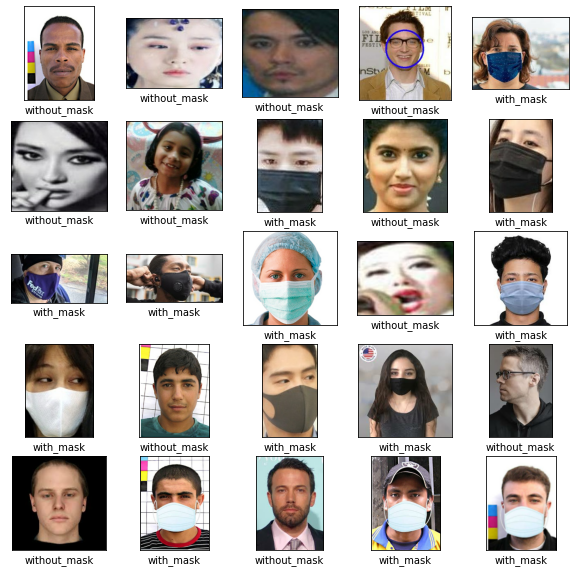

24/24 [==============================] - 35s 949ms/step - loss: 0.2181 - accuracy: 0.9987


In [ ]:
#figure dataset
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

# Evaluate the model.
loss, accuracy = model.evaluate(test_data)

# with tf.Session() as sess:
#   # ...
#   wandb.tensorflow.log(tf.summary.merge_all())

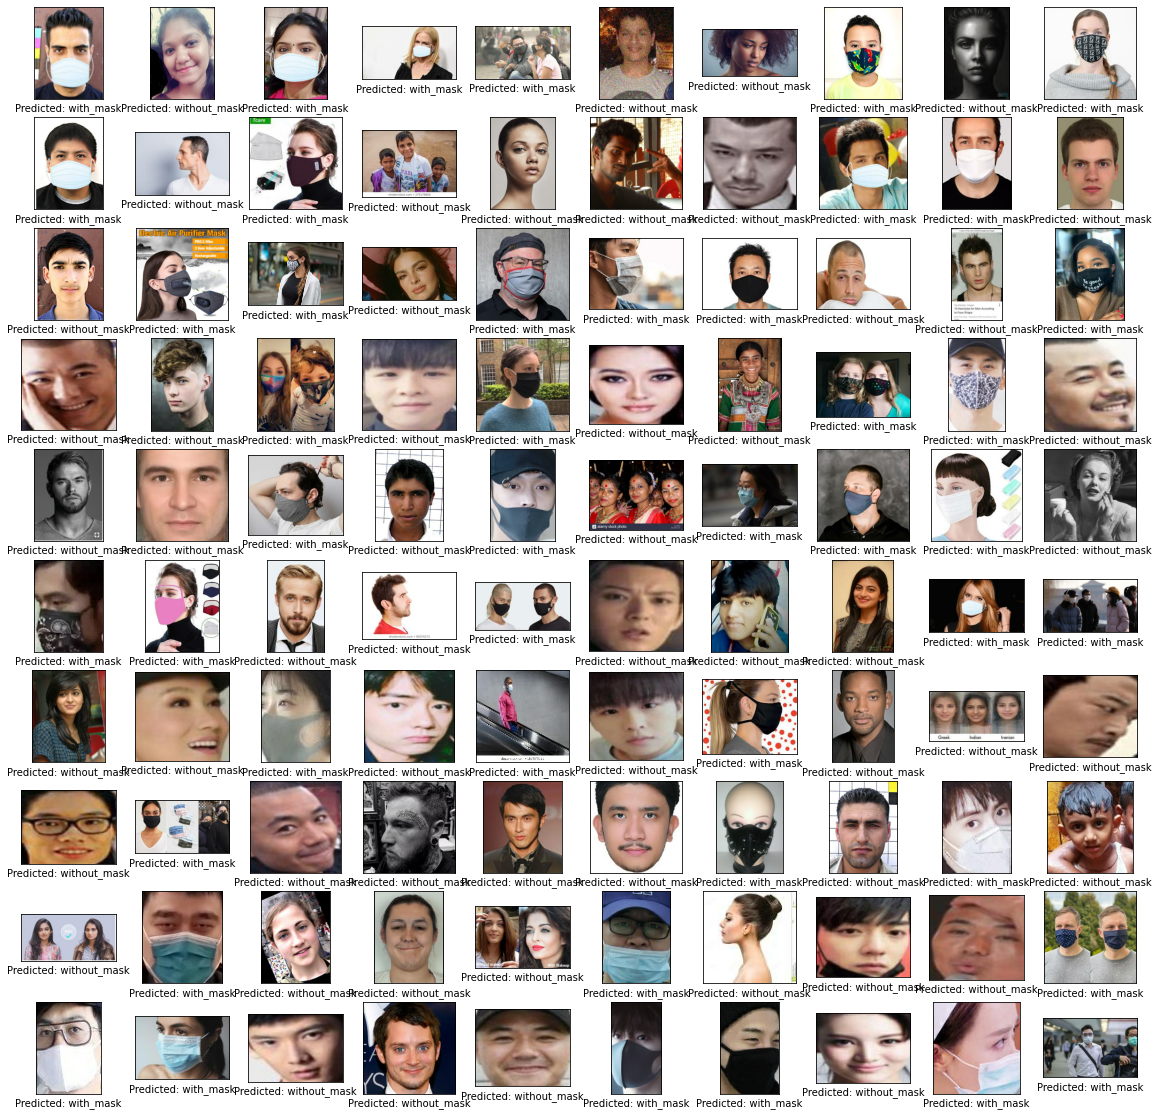

In [ ]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [ ]:
# Export to Tensorflow Lite model and label file in `export_dir`.
config = QuantizationConfig.for_float16()
model.export(export_dir='/tmp/',tflite_filename='model_fp16.tflite', quantization_config=config)

INFO:tensorflow:Assets written to: /tmp/tmpxc4tg4nt/assets


INFO:tensorflow:Assets written to: /tmp/tmpxc4tg4nt/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmp9nvhw4qe/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmp9nvhw4qe/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: /tmp/model_fp16.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: /tmp/model_fp16.tflite
